In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
    

# Define the data generators for training and validation 
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=30,
    horizontal_flip=True,
    fill_mode='nearest',
    shear_range=0.3,
    zoom_range=0.4
    )
    
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'train/'
val_dir = 'valid/'

# create the training and validation data generators add data augmentation and repeat
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=160,
    class_mode='categorical',
    shuffle=True
    )

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=160,
    class_mode='categorical',
    shuffle=True
    )




Found 2049 images belonging to 6 classes.
Found 478 images belonging to 6 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers

# Create a base model using a pre-trained ResNet50V2 model
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
# add another layer
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(6, activation='softmax')(x)

# Define the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']       

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

model.fit(train_generator,
            epochs=100,
            validation_data=val_generator,
            verbose=1)
    



Epoch 1/100
13/13 [==============================] - 23s 2s/step - loss: 1.9346 - accuracy: 0.3148 - val_loss: 1.0709 - val_accuracy: 0.5858
Epoch 2/100
13/13 [==============================] - 36s 3s/step - loss: 1.3122 - accuracy: 0.4988 - val_loss: 0.9105 - val_accuracy: 0.6632
Epoch 3/100
13/13 [==============================] - 25s 2s/step - loss: 1.1001 - accuracy: 0.5808 - val_loss: 0.8230 - val_accuracy: 0.6967
Epoch 4/100
13/13 [==============================] - 20s 2s/step - loss: 1.0842 - accuracy: 0.5905 - val_loss: 0.7885 - val_accuracy: 0.7238
Epoch 5/100
13/13 [==============================] - 21s 2s/step - loss: 1.0218 - accuracy: 0.6393 - val_loss: 0.7586 - val_accuracy: 0.7197
Epoch 6/100
13/13 [==============================] - 21s 2s/step - loss: 0.9561 - accuracy: 0.6393 - val_loss: 0.7196 - val_accuracy: 0.7469
Epoch 7/100
13/13 [==============================] - 21s 2s/step - loss: 0.9001 - accuracy: 0.6745 - val_loss: 0.6808 - val_accuracy: 0.7845
Epoch 8/100
1

In [6]:
# if dir does not exist, create it
if not os.path.exists('models'):
    os.makedirs('models')

In [7]:
# Save the model
model.save('models/ResNet50v2_Adam.h5')

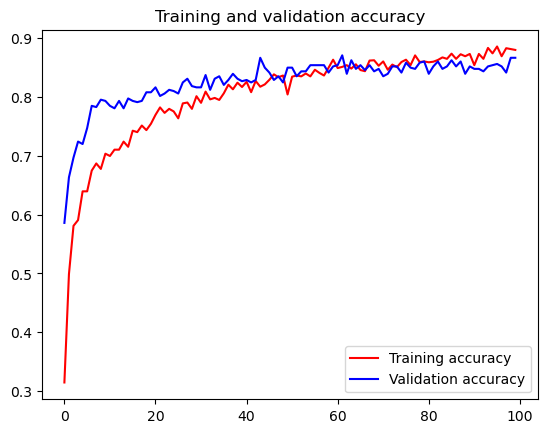

<Figure size 640x480 with 0 Axes>

In [17]:
# plot evaluation metrics
import matplotlib.pyplot as plt

acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

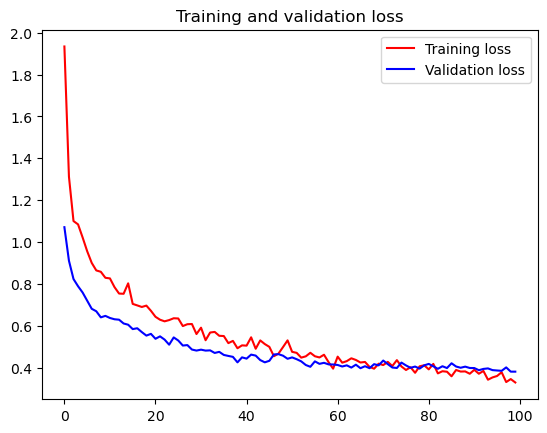

<Figure size 640x480 with 0 Axes>

In [16]:
# plot loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

3/3 [==============================] - 4s 1s/step
No of errors = 392/478
Accuracy =  17.99163179916318 %


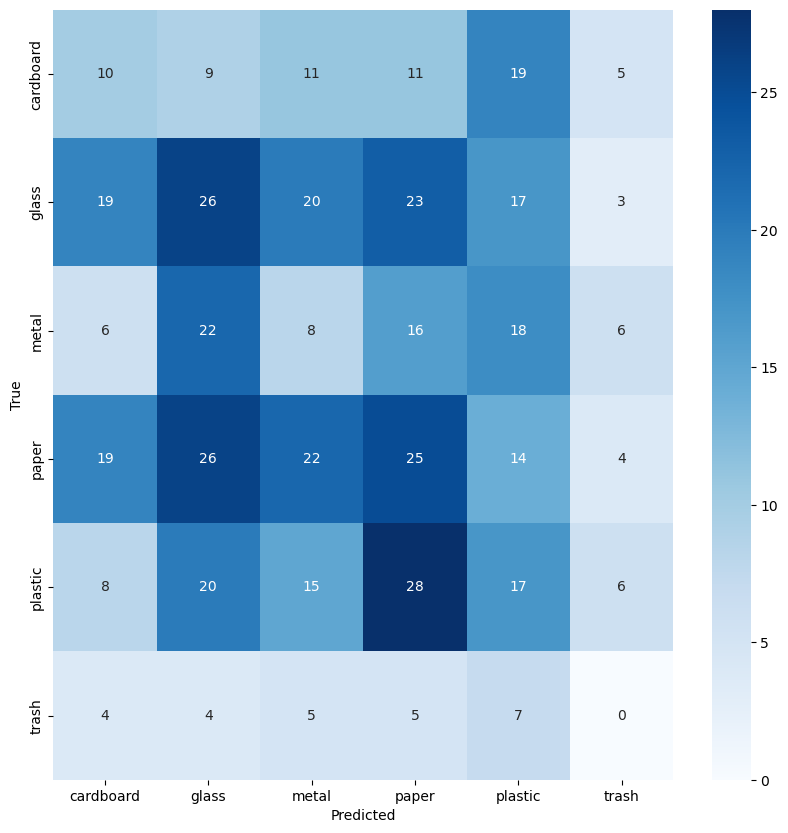

In [20]:
# plot seaborn confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# get the labels of the test images.
test_labels = val_generator.classes

# make a prediction
predictions = model.predict(val_generator)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

errors = np.where(predicted_classes != test_labels)[0]
print("No of errors = {}/{}".format(len(errors),val_generator.samples))
accuracy = (val_generator.samples-len(errors))/val_generator.samples
print("Accuracy = ", accuracy*100, "%")

cm = confusion_matrix(test_labels, predicted_classes)
cm_plot_labels = ['cardboard','glass','metal','paper','plastic','trash']

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

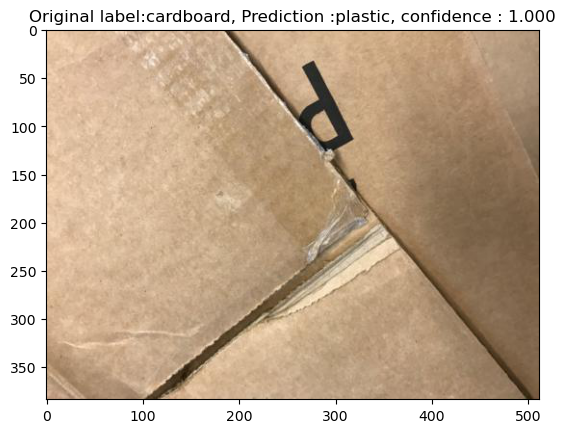

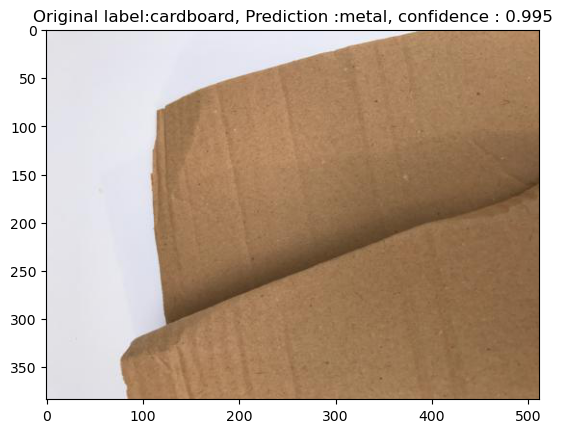

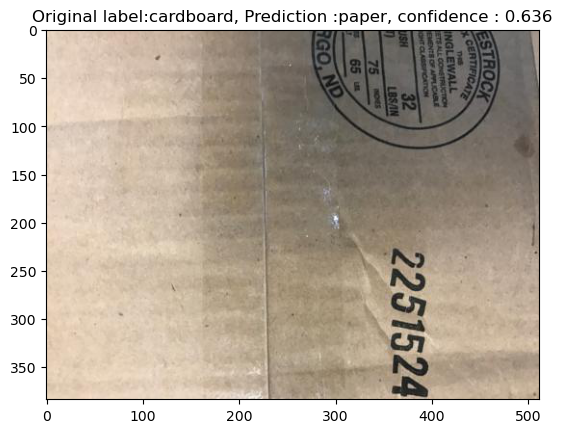

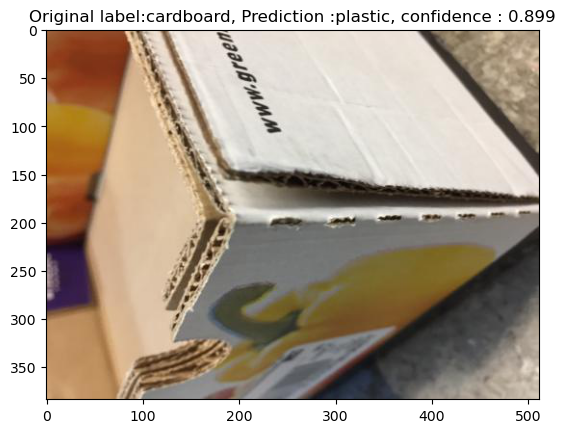

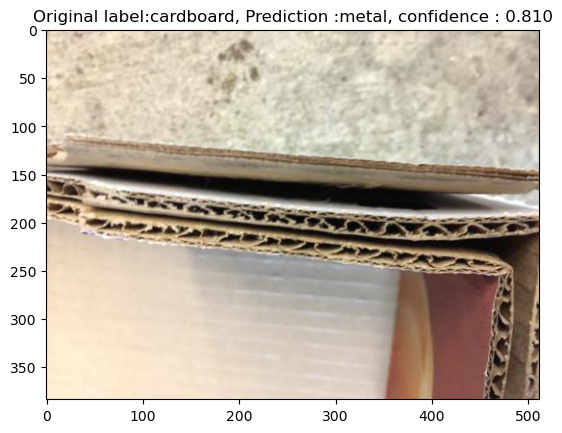

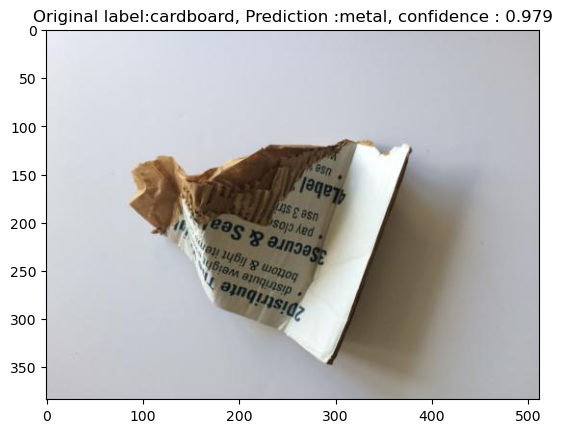

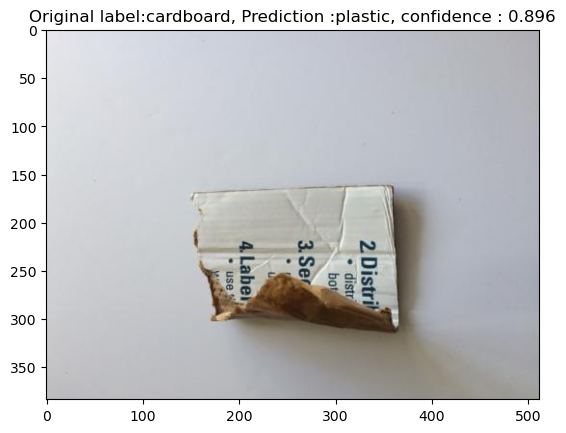

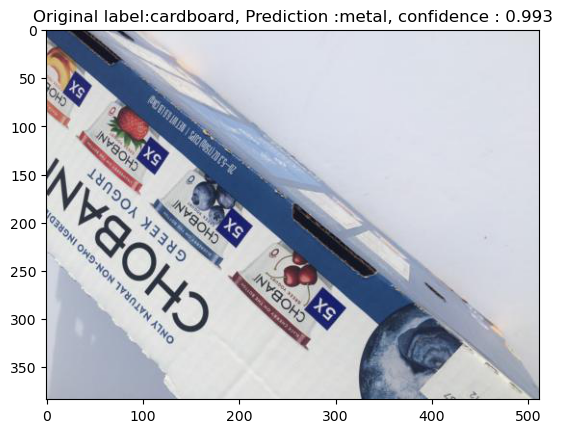

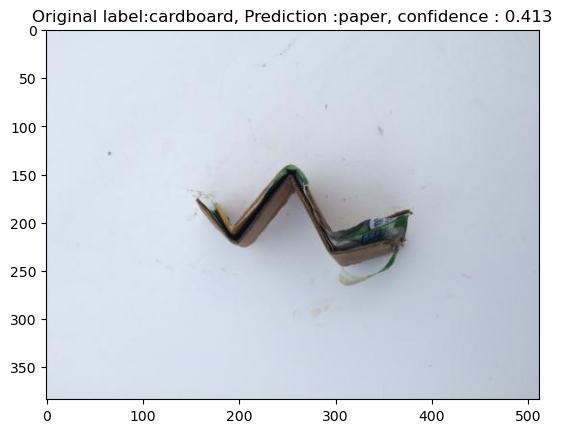

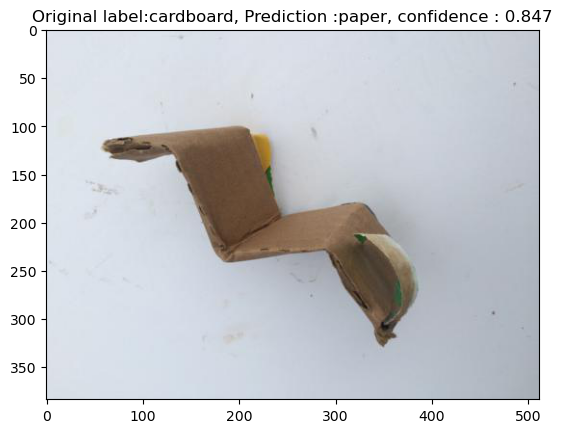

In [19]:
load_img = tf.keras.preprocessing.image.load_img

# show some misclassified examples
for i in range(len(errors)):
    ax, fig = plt.subplots(1,1)
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = cm_plot_labels[pred_class]

    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        cm_plot_labels[test_labels[errors[i]]], pred_label, predictions[errors[i]][pred_class])

    original = load_img('{}/{}'.format(val_dir, val_generator.filenames[errors[i]]))
    plt.imshow(original)
    plt.title(title)
    plt.show()
    if i == 9:
        break
